# **K BHAVISH RAJU : PES1UG22AM078**
# **K MUSADIQ PASHA : PES1UG22AM079**
# **M GOVINDARAJAN : PES1UG22AM089**

In [1]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn torch torchvision pillow opencv-python transformers captum networkx
!pip install hypernetx pyvis
!pip install networkx notebook
!pip install shap
!pip install huggingface_hub
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.4/591.4 kB 9.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 96.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: decorator
    Found existing installation: decorator 4.4.2
    Uninstalling decorator-4.4.2:
      Successfully uninstalled decorator-4.4.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
gcsfs 2024.10.0 requir

## Imports


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import shap
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image
import cv2
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
from captum.attr import GradientShap, LayerGradCam, visualization
from pyvis.network import Network
import networkx as nx
import warnings
from IPython.display import Image as Image2, display
from IPython.display import IFrame
from sklearn.cluster import KMeans
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import clip
import torch
from PIL import Image

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading & Preprocessing

### Overview
This stage prepares the dataset for modeling by handling missing values, extracting features, and transforming both tabular and categorical data.

### Key Steps

#### 1. **Load Data**
- Import metadata and image paths into a structured DataFrame.

#### 2. **Handle Missing Values**
- Drop records with missing entries to ensure clean input data.

#### 3. **Sampling**
- Select a subset of the dataset to enable faster experimentation and debugging during development.

#### 4. **Feature Engineering**
- Extract time-based features (e.g., time of day) from timestamp columns.

#### 5. **Categorical Encoding**
- Convert categorical variables into numerical format using label encoding.

#### 6. **Train-Test Split**
- Split the cleaned dataset into training and testing sets for model evaluation.

#### 7. **Feature Scaling**
- Normalize tabular features using standard scaling to ensure consistent value ranges.

### Output
- Processed training and testing sets with encoded categorical data and scaled features.


In [3]:
# Load dataset
def load_data(sample_size=5000):
    data_path = '/kaggle/input/meme-dataset/reddit_meme_data/metadata.csv'
    images_path = '/kaggle/input/meme-dataset/reddit_meme_data/images'

    df = pd.read_csv(data_path)
    print(f"Original dataset loaded with {len(df)} rows")

    # Drop rows with missing values
    df = df.dropna()
    print(f"Dataset after dropping missing values: {len(df)} rows")

    # Randomly sample N rows
    df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    print(f"Dataset after sampling {sample_size} rows: {len(df)} rows")

    return df, images_path

# Corrected data preprocessing - excluding virality indicators
def preprocess_data(df, images_path):
    # Convert timestamp to datetime and extract hour
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['hour'] = df['timestamp'].dt.hour

    # Extract time of day
    def get_time_of_day(hour):
        if 5 <= hour < 12:
            return 'morning'
        elif 12 <= hour < 17:
            return 'afternoon'
        elif 17 <= hour < 22:
            return 'evening'
        else:
            return 'night'

    df['time_of_day'] = df['hour'].apply(get_time_of_day)

    # Encode categorical variables
    le_section = LabelEncoder()
    le_time = LabelEncoder()
    df['section_encoded'] = le_section.fit_transform(df['section'])
    df['time_encoded'] = le_time.fit_transform(df['time_of_day'])

    # Only use non-virality features
    categorical_features = df[['section_encoded', 'time_encoded']]

    # Target
    y = df['virality']
    text_features = df['extracted_text']
    image_paths = df['image'].apply(lambda x: os.path.join(images_path, x))

    # Split into train/test
    X_cat_train, X_cat_test, X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test = train_test_split(
        categorical_features, image_paths, text_features, y, test_size=0.2, random_state=42
    )

    # Return everything
    return (
        X_cat_train, X_cat_test,
        X_img_train, X_img_test,
        X_txt_train, X_txt_test,
        y_train, y_test,
        df
    )

In [4]:
# Load and preprocess data
print("Loading and preprocessing data...")
df, images_path = load_data()

n = len(df)
low = []
medium = []
high = []

for i in range(n):
    if df['virality'][i] == 0:
        low.append(df['viral_score'][i])
    elif df['virality'][i] == 1:
        medium.append(df['viral_score'][i])
    else:
        high.append(df['viral_score'][i])

print(max(low), min(low))
print(max(medium), min(medium))
print(max(high), min(high))

mid = 300
df.loc[df['viral_score'] >= mid, 'virality'] = 1
df.loc[df['viral_score'] < mid, 'virality'] = 0

df['virality'].nunique()

X_tab_train, X_tab_test, X_img_train, X_img_test, X_txt_train, X_txt_test, y_train, y_test, df = preprocess_data(df, images_path)

Loading and preprocessing data...
Original dataset loaded with 5663 rows
Dataset after dropping missing values: 5601 rows
Dataset after sampling 5000 rows: 5000 rows
105.6 0.0
948.8 105.8
56442.4 949.6


In [5]:
print(df['virality'].value_counts())

virality
1    2604
0    2396
Name: count, dtype: int64


## Pipeline 1: Tabular Hypergraph-Based Classification

### Overview
This pipeline builds a hypergraph representation of tabular data and uses it for classification with a custom neural network model.

### Key Components

#### 1. **HypergraphNN Class**
- A neural network model consisting of 3 fully connected layers with ReLU activations and dropout for regularization.

#### 2. **Build Hypergraph Function**
- **K-Means Clustering**: Creates clusters of data points and forms hyperedges.
- **Incidence Matrix**: Represents nodes and hyperedges.
- **Laplacian Calculation**: Computes the hypergraph Laplacian using node and hyperedge degrees.
- **Visualization**: Builds a graph to visualize the hypergraph structure.

#### 3. **Training the Hypergraph Model**
- **Data Preparation**: Combines tabular data with hypergraph Laplacian eigenvectors.
- **Model**: Trains the `HypergraphNN` model using PyTorch, CrossEntropyLoss, and Adam optimizer.
- **Evaluation**: Evaluates the model using accuracy score and classification report.

#### 4. **PyVis Visualization**
- Uses PyVis to visualize the hypergraph as a network with customizable options for nodes, edges, and physics.

#### 5. **Confusion Matrix**
- Visualizes the confusion matrix for model performance with a heatmap.

#### 6. **Inference**
- A function to scale input data, build the hypergraph, and make predictions with the trained model.

### Outputs
- **Trained Model**: The hypergraph model (`model`).
- **Hypergraph Visualization**: Network graph saved as `graph_visualization.html`.
- **Confusion Matrix**: Saved as `Confusion Matrix Hypergraph Model.png`.

### Key Notes
- Uses K-means clustering for hypergraph creation.
- Integrates tabular data with eigenvectors from the hypergraph Laplacian for model input.
- Visualizes both the hypergraph structure and confusion matrix.


In [6]:
# Pipeline 1: Tabular Hypergraph-Based Classification


class HypergraphNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(HypergraphNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def build_hypergraph(X, n_clusters=8):
    from sklearn.cluster import KMeans

    # Use K-means clustering to create hyperedges
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)

    # Create hyperedges based on clusters
    hyperedges = {}
    for i in range(n_clusters):
        hyperedges[i] = np.where(cluster_labels == i)[0]

    # Create incidence matrix (nodes x hyperedges)
    n_nodes = X.shape[0]
    H = np.zeros((n_nodes, n_clusters))

    for i, nodes in hyperedges.items():
        H[nodes, i] = 1

    # Calculate hypergraph Laplacian
    D_v = np.sum(H, axis=1)  # Node degrees
    D_e = np.sum(H, axis=0)  # Hyperedge degrees

    # Avoid division by zero
    D_v_inv = np.diag(1.0 / np.maximum(D_v, 1e-10))
    D_e_inv = np.diag(1.0 / np.maximum(D_e, 1e-10))

    # Hypergraph Laplacian
    L = np.eye(n_nodes) - D_v_inv @ H @ D_e_inv @ H.T

    # For visualization
    G = nx.Graph()
    for i in range(n_nodes):
        G.add_node(i)

    # Add edges between nodes that share a hyperedge
    for edge_idx, nodes in hyperedges.items():
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                G.add_edge(nodes[i], nodes[j])

    return H, L, G, hyperedges

def train_hypergraph_model(X_train, y_train, X_test, y_test,sample_size=100):
    #scaler = StandardScaler()
    #X_train_scaled = scaler.fit_transform(X_train)
    #X_test_scaled = scaler.transform(X_test)
    X_train_scaled = X_train
    X_test_scaled = X_test
    
    # Build hypergraph representation
    H, L, G, hyperedges = build_hypergraph(X_train)

    # Print Hypergraph Stats
    print("=== Hypergraph Stats ===")
    print(f"Number of Nodes: {G.number_of_nodes()}")
    print(f"Number of Edges: {G.number_of_edges()}")
    print(f"Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
    print(f"Number of Hyperedges: {len(hyperedges)}")
    print("=========================")

    # Combine original features with hypergraph Laplacian eigenvectors
    eigvals, eigvecs = np.linalg.eigh(L)
    k = 3
    X_train_hyper = np.hstack([X_train, eigvecs[:, 1:k+1]])

    # Apply same transformation to test data
    H_test, L_test, _, _ = build_hypergraph(X_test, n_clusters=len(hyperedges))
    eigvals_test, eigvecs_test = np.linalg.eigh(L_test)
    X_test_hyper = np.hstack([X_test, eigvecs_test[:, 1:k+1]])

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_hyper)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test_hyper)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create and train the model
    input_dim = X_train_hyper.shape[1]
    model = HypergraphNN(input_dim, 64, 2).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 100
    batch_size = 64

    train_loader = DataLoader(
        list(zip(X_train_tensor, y_train_tensor)),
        batch_size=batch_size,
        shuffle=True
    )

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

    accuracy = accuracy_score(y_test, predicted)
    print(f"Hypergraph Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, predicted))
    
    
    # Convert node IDs to strings for PyVis compatibility
    
    
    G = nx.relabel_nodes(G, lambda x: str(x))
    
    # Create PyVis network
    net = Network(
        notebook=True,
        width="1080px",
        height="1080px",
        bgcolor="#1e1e1e",
        font_color="white",
        cdn_resources="in_line"
    )
    
    # Set visualization options
    net.set_options("""
    var options = {
      "nodes": {
        "shape": "dot",
        "size": 15,
        "font": {
          "size": 18,
          "color": "#ffffff"
        },
        "borderWidth": 2,
        "borderWidthSelected": 4
      },
      "edges": {
        "color": {
          "color": "#aaaaaa",
          "highlight": "#ff6f61"
        },
        "width": 2,
        "font": {
          "size": 14,
          "color": "#ffffff",
          "align": "middle"
        },
        "smooth": {
          "type": "continuous",
          "forceDirection": "none",
          "roundness": 0.5
        }
      },
      "physics": {
        "enabled": true,
        "barnesHut": {
          "gravitationalConstant": -20000,
          "centralGravity": 0.3,
          "springLength": 95,
          "springConstant": 0.04,
          "damping": 0.09
        },
        "minVelocity": 0.75
      },
      "interaction": {
        "hover": true,
        "multiselect": true,
        "navigationButtons": true,
        "tooltipDelay": 200
      }
    }
    """)

    sampled_nodes = random.sample(G.nodes(), min(sample_size, len(G.nodes())))
    G = G.subgraph(sampled_nodes).copy()
    
    # Add nodes
    for node in G.nodes:
        net.add_node(node, label=node)
    
    # Add edges with labels (weights/relations)
    for u, v, data in G.edges(data=True):
        label = str(data.get('weight', ''))  # Replace 'weight' with any attribute name like 'relation'
        net.add_edge(u, v, label=label)
    
    # Show the network
    net.show("graph_visualization.html")


    # Visualize confusion matrix
    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'High'],
                yticklabels=['Low', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Hypergraph Model')
    plt.savefig('Confusion Matrix Hypergraph Model.png')
    plt.close()

    return model, G, hyperedges


def hypergraph_inference(model, X, scaler):
    """Function for inferring virality using the hypergraph model"""
    # Scale input features
    #X_scaled = scaler.transform(X)
    X_scaled = X

    # Build hypergraph representation
    H, L, _, _ = build_hypergraph(X_scaled, n_clusters=5)

    # Get eigenvectors from Laplacian
    eigvals, eigvecs = np.linalg.eigh(L)
    k = 3
    X_hyper = np.hstack([X_scaled, eigvecs[:, 1:k+1]])

    # Convert to PyTorch tensor
    X_tensor = torch.FloatTensor(X_hyper).to(device)

    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

    return predicted.cpu().numpy(), probs.cpu().numpy()

In [7]:
# Pipeline 1: Hypergraph-based model
print("\n--- Training Hypergraph Model ---")
hypergraph_model, graph, hyperedges = train_hypergraph_model(X_tab_train, y_train, X_tab_test, y_test, 100) # viz for sample
print('\n\n Done\n\n')


--- Training Hypergraph Model ---
=== Hypergraph Stats ===
Number of Nodes: 4000
Number of Edges: 1473749
Average Degree: 736.87
Number of Hyperedges: 8
Epoch 0, Loss: 0.8517
Epoch 10, Loss: 0.6311
Epoch 20, Loss: 0.6248
Epoch 30, Loss: 0.6207
Epoch 40, Loss: 0.6207
Epoch 50, Loss: 0.6180
Epoch 60, Loss: 0.6172
Epoch 70, Loss: 0.6161
Epoch 80, Loss: 0.6184
Epoch 90, Loss: 0.6151
Hypergraph Model Accuracy: 0.6680

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.40      0.54       475
           1       0.63      0.91      0.74       525

    accuracy                           0.67      1000
   macro avg       0.71      0.66      0.64      1000
weighted avg       0.71      0.67      0.64      1000

graph_visualization.html


 Done




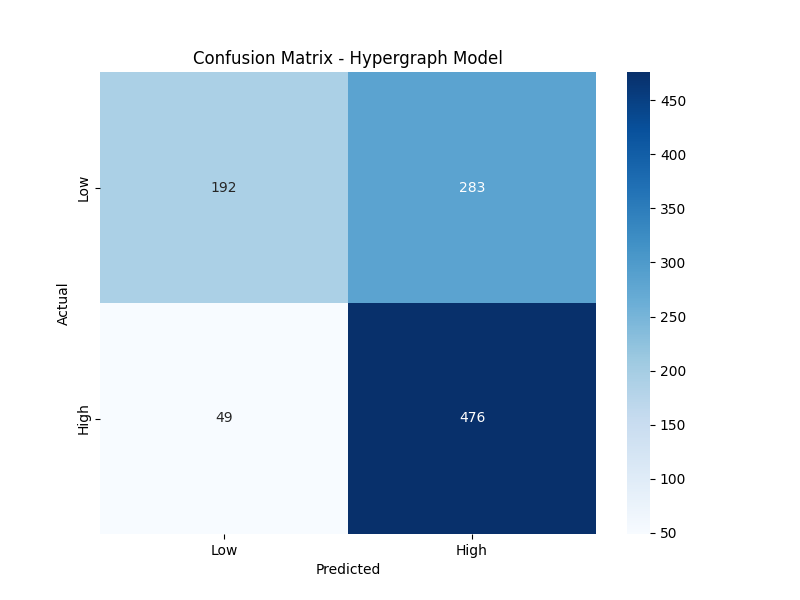

In [8]:
display(Image2(filename='Confusion Matrix Hypergraph Model.png'))

IFrame('graph_visualization.html', width='100%', height='600')

## Pipeline 2: Image-Based Classification with Explainability

### Overview
A meme image classification pipeline using EfficientNet with Grad-CAM for explainability.

### Key Components

#### 1. **MemeImageDataset Class**
- Custom dataset that loads and transforms meme images with labels.

#### 2. **Data Transformations**
- **Train**: Resize, random crop, flip, jitter, normalize.  
- **Test**: Resize, normalize.

#### 3. **Model Training**
- **Model**: EfficientNet-B0, modified for 3-class classification.  
- **Optimizer**: AdamW  
- **Loss**: CrossEntropyLoss  
- **Scheduler**: ReduceLROnPlateau (monitors accuracy)  
- **Training Loop**: Runs training & evaluation, saves best model.

#### 4. **Final Evaluation**
- Generates classification report, confusion matrix, and Grad-CAM visualizations.

#### 5. **Grad-CAM Explainability**
- Visualizes attention heatmaps over input memes to interpret decisions.

#### 6. **Inference**
- Takes an image input, applies transformations, and outputs predicted class.

### Outputs
- **Model**: `best_meme_model.pth`  
- **Confusion Matrix**: `image_confusion_matrix.png`  
- **Grad-CAM**: `gradcam_visualization.png`


In [9]:
# Pipeline 2: Image-Based Classification with Explainability (using CLIP)

class MemeImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths.iloc[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image at {img_path}: {e}")
            image = Image.new('RGB', (224, 224), color='gray')
        if self.transform:
            image = self.transform(image)
        label = self.labels.iloc[idx]
        return image, label

class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, embed_dim=512, num_classes=2):
        super(CLIPClassifier, self).__init__()
        self.clip_model = clip_model
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            x = self.clip_model.encode_image(x).float()
        return self.classifier(x)

def train_image_model(X_img_train, y_train, X_img_test, y_test, images_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
    
    train_dataset = MemeImageDataset(X_img_train, y_train, transform=clip_preprocess)
    test_dataset = MemeImageDataset(X_img_test, y_test, transform=clip_preprocess)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = CLIPClassifier(clip_model, embed_dim=512, num_classes=2).to(device)
    
    optimizer = optim.AdamW(model.classifier.parameters(), lr=3e-4, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
    
    n_epochs = 10
    best_accuracy = 0.0

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation phase
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                _, preds = torch.max(F.softmax(outputs, dim=1), 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")
        scheduler.step(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_meme_model.pth')

    model.load_state_dict(torch.load('best_meme_model.pth'))

    # Final evaluation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Image Model Final Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'High'],
                yticklabels=['Low', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Image Model (CLIP)')
    plt.savefig('image_confusion_matrix.png')
    plt.close()

    return model, clip_preprocess


def image_inference(model, image_path, transform):
    import torchvision.transforms as T
    from PIL import Image
    import torch.nn.functional as F
    import numpy as np
    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if transform is None:
        print("CLIP requires its own preprocessing. Please pass the correct transform from clip.load().")
        return

    try:
        image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Error opening image: {e}")
        image = Image.new('RGB', (224, 224), color='gray')

    image_tensor = transform(image).unsqueeze(0).to(device)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probs, 1)

    # Visualization (without Grad-CAM)
    orig_img = np.array(image.resize((224, 224))) / 255.0
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(orig_img)
    ax.set_title(f"Prediction: {['Low', 'High'][predicted.item()]}")
    ax.axis('off')

    return predicted.cpu().numpy(), probs.cpu().numpy(), fig

In [10]:
# Pipeline 2: Image-based model with enhanced features # EFFIECNT NET
print("\n--- Training Image Model ---")
image_model, image_transform = train_image_model(X_img_train, y_train, X_img_test, y_test, images_path)
print('\n\n Done\n\n')


--- Training Image Model ---


100%|███████████████████████████████████████| 338M/338M [00:07<00:00, 47.0MiB/s]


Epoch 1/10, Loss: 0.6234, Accuracy: 0.6690
Epoch 2/10, Loss: 0.5921, Accuracy: 0.6770
Epoch 3/10, Loss: 0.5750, Accuracy: 0.6770
Epoch 4/10, Loss: 0.5576, Accuracy: 0.6700
Epoch 5/10, Loss: 0.5443, Accuracy: 0.6690
Epoch 6/10, Loss: 0.5255, Accuracy: 0.6760
Epoch 7/10, Loss: 0.5119, Accuracy: 0.6790
Epoch 8/10, Loss: 0.5042, Accuracy: 0.6750
Epoch 9/10, Loss: 0.4916, Accuracy: 0.6670
Epoch 10/10, Loss: 0.4847, Accuracy: 0.6780
Image Model Final Accuracy: 0.6790

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.55      0.62       475
           1       0.66      0.79      0.72       525

    accuracy                           0.68      1000
   macro avg       0.69      0.67      0.67      1000
weighted avg       0.68      0.68      0.67      1000



 Done




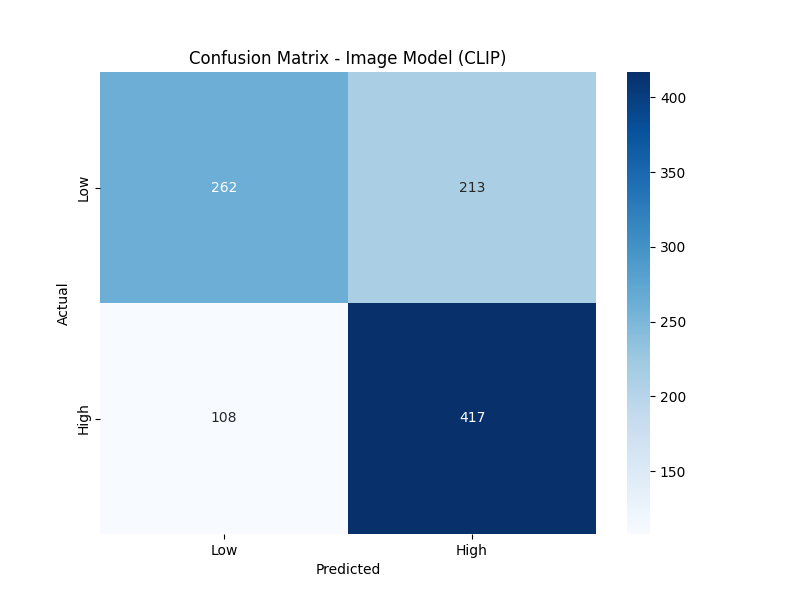

In [11]:
display(Image2(filename='/kaggle/working/image_confusion_matrix.png'))

## Pipeline 3: Text-Based Classification with Explainability

### Overview
A pipeline that classifies meme text using BERT and explains predictions using attention weights and SHAP values.

### Key Components

#### 1. **MemeTextDataset Class**
- Prepares text data by tokenizing and converting to input tensors for BERT.

#### 2. **Model Training**
- **Model**: Pre-trained BERT fine-tuned for 3-class classification.  
- **Optimizer**: AdamW  
- **Epochs**: 1  
- **Loss & Evaluation**: Computes loss, updates weights, evaluates with classification metrics.  
- **Visualizations**: Confusion matrix and attention weights for selected examples.

#### 3. **Explainability**
- **Attention Weights**: Highlights words that influenced predictions.  
- **SHAP**: Generates SHAP value plots to explain model output. Includes fallback if SHAP fails.

#### 4. **Inference**
- Tokenizes and predicts class for input text, and generates explanations using attention and SHAP.

### Outputs
- **Confusion Matrix**: `text_confusion_matrix.png`  
- **Attention Plots**: For 3 random inputs  
- **SHAP Plots**: Feature importance visualizations

In [12]:
# Pipeline 3: Text-Based Classification with Explainability

class MemeTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
def train_text_model(X_txt_train, y_train, X_txt_test, y_test):
    # Initialize tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=True
    )
    model = model.to(device)
    # Create datasets
    train_dataset = MemeTextDataset(X_txt_train, y_train, tokenizer)
    test_dataset = MemeTextDataset(X_txt_test, y_test, tokenizer)
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    # Training loop
    n_epochs = 10
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    # Evaluation
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    all_attentions = []
    all_input_ids = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_attentions=True
            )
            logits = outputs.logits
            attentions = outputs.attentions
            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(logits, 1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.numpy())
            # Store attention weights and input IDs for later visualization
            all_attentions.extend([att.cpu().numpy() for att in attentions])
            all_input_ids.extend(input_ids.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Text Model Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Low', 'High'],
                yticklabels=['Low', 'High'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Text Model')
    plt.savefig('text_confusion_matrix.png')
    plt.close()
    
    # Visualize attention weights (robust version)
    examples = []
    
    valid_indices = list(range(min(len(all_attentions), len(X_txt_test))))
    sampled_indices = np.random.choice(valid_indices, size=3, replace=False)
    
    for idx in sampled_indices:
        attn_data = all_attentions[idx]
        if attn_data is not None and attn_data[0].shape[-1] > 0:
            examples.append({
                'text': X_txt_test.iloc[idx],
                'true_label': all_labels[idx],
                'pred_label': all_preds[idx],
                'attention': attn_data[0],
                'input_ids': all_input_ids[idx]
            })
    
    # Check if all_attentions has sufficient data for visualization
    if len(examples) > 0:
        # Visualize attention weights
        fig, axes = plt.subplots(3, 1, figsize=(20, 6))
        for i, example in enumerate(examples):
            # Decode tokens
            tokens = tokenizer.convert_ids_to_tokens(example['input_ids'])
    
            # Get attention weights for visualization (average across heads)
            attn = np.mean(example['attention'], axis=0)
    
            # Create heatmap
            ax = axes[i]
            im = ax.imshow(attn, cmap='viridis')
            ax.set_xticks(range(len(tokens)))
            ax.set_xticklabels(tokens, rotation=90, fontsize=8)
            ax.set_yticks([])
            
            ax.set_title(f"Text: '{example['text'][:50]}...'\n" +
                         f"True: {['Low', 'High'][example['true_label']]}, " +
                         f"Pred: {['Low', 'High'][example['pred_label']]}")
    
        fig.suptitle("Attention Weights per Token", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Reserve space for suptitle
        plt.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
        plt.savefig('text_attention_visualization.png')
        plt.close()
    
    # Add SHAP visualization for model explainability
    try:
        import shap
        
        # Create a pipeline compatible with SHAP
        from transformers import pipeline
        classifier = pipeline(
            "text-classification", 
            model=model, 
            tokenizer=tokenizer, 
            return_all_scores=True, 
            device=0 if torch.cuda.is_available() else -1
        )
        
        # Sample texts from test dataset
        sample_size = min(3, len(X_txt_test))
        sample_indices = np.random.choice(range(len(X_txt_test)), size=sample_size, replace=False)
        example_texts = [str(X_txt_test.iloc[idx]) for idx in sample_indices]
        
        # Set up SHAP explainer
        explainer = shap.Explainer(classifier)
        shap_values = explainer(example_texts)
        
        # Visualize SHAP values
        plt.figure(figsize=(12, 8))
        for i, text in enumerate(example_texts):
            # Get prediction
            class_scores = classifier(text)[0]
            pred_class = max(class_scores, key=lambda x: x['score'])
            label = pred_class['label']
            confidence = pred_class['score']
            
            print(f"\n📝 Text: {text[:100]}...")
            print(f"🔮 Predicted Class: {label} ({confidence:.2f})")
            
            # Create separate figure for each SHAP plot
            plt.figure(figsize=(12, 4))
            shap.plots.text(shap_values[i])
            plt.tight_layout()
            plt.savefig(f'shap_visualization_{i}.png')
            plt.close()
            
    except Exception as e:
        print(f"Could not generate SHAP visualizations: {str(e)}")
    
    return model, tokenizer

def text_inference(model, text, tokenizer):
    """Function for inferring virality using the text model"""
    # Tokenize the input text
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    # Get prediction
    model.eval()
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )
        logits = outputs.logits
        attentions = outputs.attentions
        probs = F.softmax(logits, dim=1)
        _, predicted = torch.max(logits, 1)
    
    # Add SHAP explanation
    try:
        import shap
        from transformers import pipeline
        
        classifier = pipeline(
            "text-classification", 
            model=model, 
            tokenizer=tokenizer, 
            return_all_scores=True, 
            device=0 if torch.cuda.is_available() else -1
        )
        
        # Generate SHAP explanation
        explainer = shap.Explainer(classifier)
        shap_values = explainer([text])
        
        # Get prediction details
        class_scores = classifier(text)[0]
        pred_class = max(class_scores, key=lambda x: x['score'])
        label = pred_class['label']
        confidence = pred_class['score']
        
        print(f"\n📝 Text: {text}")
        print(f"🔮 Predicted Class: {label} ({confidence:.2f})")
        
        # Create SHAP visualization figure
        shap_fig = plt.figure(figsize=(12, 4))
        shap.plots.text(shap_values[0])
        plt.tight_layout()
        
        return predicted.cpu().numpy(), probs.cpu().numpy(), shap_fig
    except:
        # If SHAP fails, return just the prediction and probabilities
        return predicted.cpu().numpy(), probs.cpu().numpy() , 0


In [13]:
# Pipeline 3: Text-based model
print("\n--- Training Text Model ---")
text_model, tokenizer = train_text_model(X_txt_train, y_train, X_txt_test, y_test)
print('\n\n Done ✅\n\n')


--- Training Text Model ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Epoch 1/10, Loss: 0.6666
Epoch 2/10, Loss: 0.5836
Epoch 3/10, Loss: 0.4231
Epoch 4/10, Loss: 0.2487
Epoch 5/10, Loss: 0.1443
Epoch 6/10, Loss: 0.1135
Epoch 7/10, Loss: 0.0743
Epoch 8/10, Loss: 0.0603
Epoch 9/10, Loss: 0.0638
Epoch 10/10, Loss: 0.0513
Text Model Accuracy: 0.6260

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.61      0.61       475
           1       0.64      0.64      0.64       525

    accuracy                           0.63      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.63      0.63      0.63      1000



Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


  0%|          | 0/498 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:17, 17.61s/it]               


📝 Text: When your friend needs help with their slow pc and you remember about deleting System32 You know; Im...
🔮 Predicted Class: LABEL_1 (1.00)



📝 Text: KILLS PEWDIEPIE MEMES MIND MY CHANGE...
🔮 Predicted Class: LABEL_1 (1.00)



📝 Text: israel {ounded Nowg Inagos Vidcos Mcte 5 08619 About 7. 91,00,0o0 (034E5 (0,E6 acconds) Israel Found...
🔮 Predicted Class: LABEL_1 (1.00)




 Done ✅




<Figure size 1200x800 with 0 Axes>

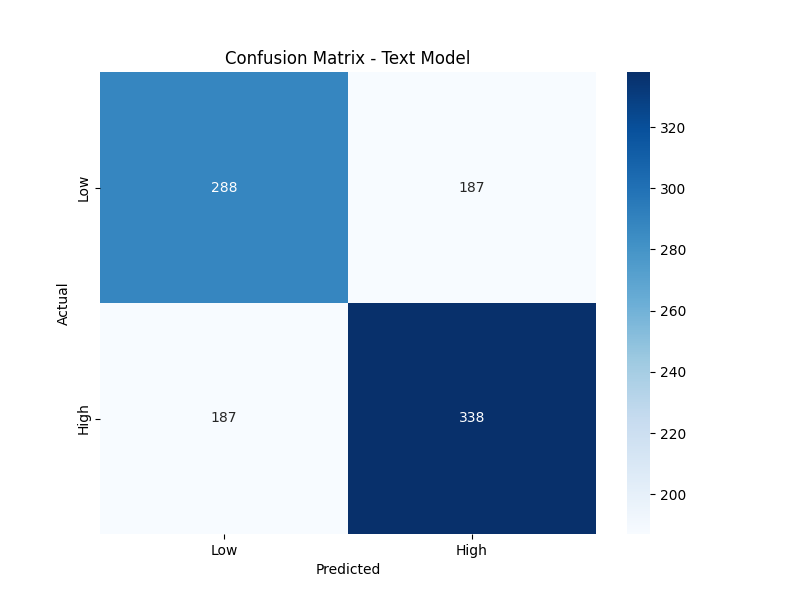

In [14]:

display(Image2(filename='/kaggle/working/text_confusion_matrix.png'))


In [15]:
# Evaluate individual models on the test set
print("\n--- Evaluating Individual Models ---")

# Hypergraph model predictions
scaler = StandardScaler()
tab_pred, tab_prob = hypergraph_inference(hypergraph_model, X_tab_test, scaler)

# Image model predictions
all_img_preds = []
all_img_probs = []

test_img_dataset = MemeImageDataset(X_img_test, y_test, transform=image_transform)
test_img_loader = DataLoader(test_img_dataset, batch_size=32, shuffle=False)

image_model.eval()
with torch.no_grad():
    for images, _ in test_img_loader:
        images = images.to(device)
        outputs = image_model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        all_img_preds.extend(preds.cpu().numpy())
        all_img_probs.extend(probs.cpu().numpy())

img_pred = np.array(all_img_preds)
img_prob = np.array(all_img_probs)

# Text model predictions
all_txt_preds = []
all_txt_probs = []

test_txt_dataset = MemeTextDataset(X_txt_test, y_test, tokenizer)
test_txt_loader = DataLoader(test_txt_dataset, batch_size=16, shuffle=False)

text_model.eval()
with torch.no_grad():
    for batch in test_txt_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = text_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        _, preds = torch.max(logits, 1)

        all_txt_preds.extend(preds.cpu().numpy())
        all_txt_probs.extend(probs.cpu().numpy())

txt_pred = np.array(all_txt_preds)
txt_prob = np.array(all_txt_probs)
print('\n\n Done\n\n')


--- Evaluating Individual Models ---


 Done




## Evaluate Individual Models

### Overview
Each model—tabular (hypergraph), image, and text—is evaluated independently to obtain predictions and probability scores for downstream fusion.

### Key Steps

#### 1. **Hypergraph Model Evaluation**
- Perform inference on the tabular data using the trained Hypergraph model.
- Store predicted labels in `tab_pred`.
- Store softmax probability scores in `tab_prob`.

#### 2. **Image Model Evaluation**
- Load the image test dataset using a `DataLoader`.
- Set the model to evaluation mode (`eval()`).
- Compute softmax probabilities and predicted classes.
- Store predictions in `img_pred` and probabilities in `img_prob`.

#### 3. **Text Model Evaluation**
- Load the text test dataset using a `DataLoader`.
- Set the model to evaluation mode.
- Compute softmax probabilities and predicted classes.
- Store predictions in `txt_pred` and probabilities in `txt_prob`.

### Output
- Label predictions and probabilities for each modality stored for fusion.


## Ensemble Model – Weighted Fusion

### 1. Ensemble Predictions
- Fuse the probabilities from the **tabular**, **image**, and **text** models using a weighted sum: `ensemble_prob = 0.2 * tab_prob + 0.4 * img_prob + 0.4 * txt_prob`

- Derive final predictions by taking the `argmax` over `ensemble_prob`.

### 2. Evaluate Ensemble Model
- Store final predicted labels in `ensemble_pred`.
- Print or log both `ensemble_pred` and `ensemble_prob`.
- Compute **Ensemble Accuracy** using `accuracy_score`.
- Generate a **classification report** to assess performance across classes.

### 3. Confusion Matrix
- Plot the confusion matrix for the ensemble predictions.
- Save the figure as `ensemble_confusion_matrix.png`.

  


In [16]:
# -------------------------------------------
# Ensemble Model - Weighted Fusion
# -------------------------------------------
def ensemble_predictions(tab_pred, tab_prob, img_pred, img_prob, txt_pred, txt_prob):
    # Ensure all inputs are numpy arrays
    tab_prob = np.array(tab_prob)
    img_prob = np.array(img_prob)
    txt_prob = np.array(txt_prob)

    # Ensemble by averaging probabilities for each sample
    #weighted_probs = (tab_prob + img_prob + txt_prob) / 3.0  # shape: (n_samples, n_classes)
    weighted_probs = 0.4 * tab_prob + 0.4 * img_prob + 0.2 * txt_prob


    # Final predictions: pick class with max probability per sample
    final_pred = np.argmax(weighted_probs, axis=1)  # shape: (n_samples,)

    return final_pred, weighted_probs

# Ensemble predictions
print("\n--- Ensemble Model Evaluation ---")
ensemble_pred, ensemble_prob = ensemble_predictions(tab_pred, tab_prob, img_pred, img_prob, txt_pred, txt_prob)
print(ensemble_pred)
print(ensemble_prob)

ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, ensemble_pred))

# Confusion matrix for ensemble model
cm = confusion_matrix(y_test, ensemble_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'High'],
            yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.savefig('ensemble_confusion_matrix.png')
plt.close()
print('\n\n Done\n\n')



--- Ensemble Model Evaluation ---
[1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1
 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0
 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1
 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1
 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1
 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1
 0 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 1
 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1
 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 

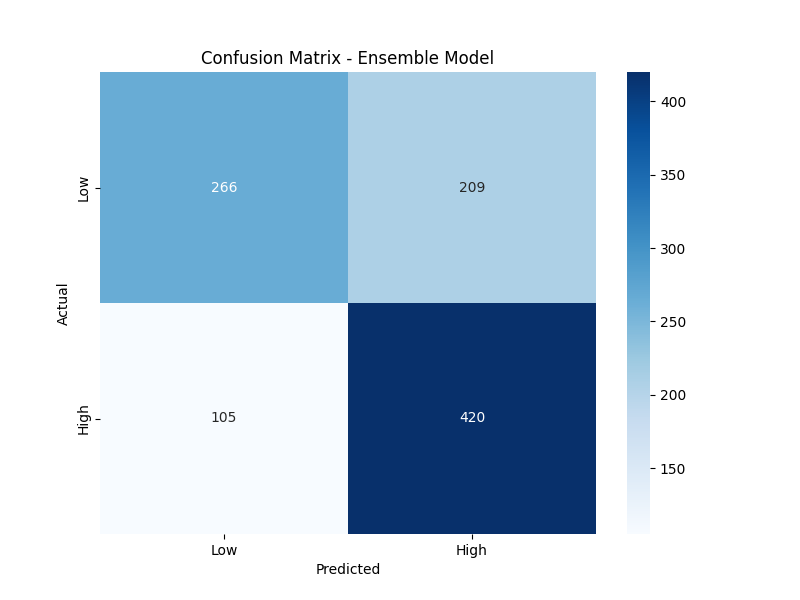

In [17]:
display(Image2(filename='/kaggle/working/ensemble_confusion_matrix.png'))

## Model Performance Comparison

### 1. Accuracy Calculation
- Compute accuracy scores for each individual model:
  - `tab_accuracy` → Hypergraph Model
  - `img_accuracy` → Image Model
  - `txt_accuracy` → Text Model
  - `ensemble_accuracy` → Ensemble Model

### 2. Display Model Performance
- Print all four model accuracies to compare performance:
  - Tabular (Hypergraph)
  - Image
  - Text
  - Ensemble

### 3. Plot Comparison
- Generate a **bar chart** to visually compare the accuracies.
- Annotate each bar with its corresponding accuracy value.
- Save the final plot as: `model_comparison.png`


In [18]:
# Compare model performances
tab_accuracy = accuracy_score(y_test, tab_pred)
img_accuracy = accuracy_score(y_test, img_pred)
txt_accuracy = accuracy_score(y_test, txt_pred)

print("\n--- Model Performance Comparison ---")
print(f"Hypergraph Model Accuracy: {tab_accuracy:.4f}")
print(f"Image Model Accuracy: {img_accuracy:.4f}")
print(f"Text Model Accuracy: {txt_accuracy:.4f}")
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")

# Plot model comparison
model_names = ['Hypergraph', 'Image', 'Text', 'Ensemble']
accuracies = [tab_accuracy, img_accuracy, txt_accuracy, ensemble_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['lightblue', 'lightgreen', 'salmon', 'gold'])

# Add accuracy values on top of bars
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
              f'{accuracy:.4f}', ha='center', fontweight='bold')

plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0, max(accuracies) + 0.1)  # Add some space for labels
plt.savefig('model_comparison.png')
plt.close()
print('\n\n Done\n\n')


--- Model Performance Comparison ---
Hypergraph Model Accuracy: 0.6680
Image Model Accuracy: 0.6790
Text Model Accuracy: 0.6260
Ensemble Model Accuracy: 0.6860


 Done




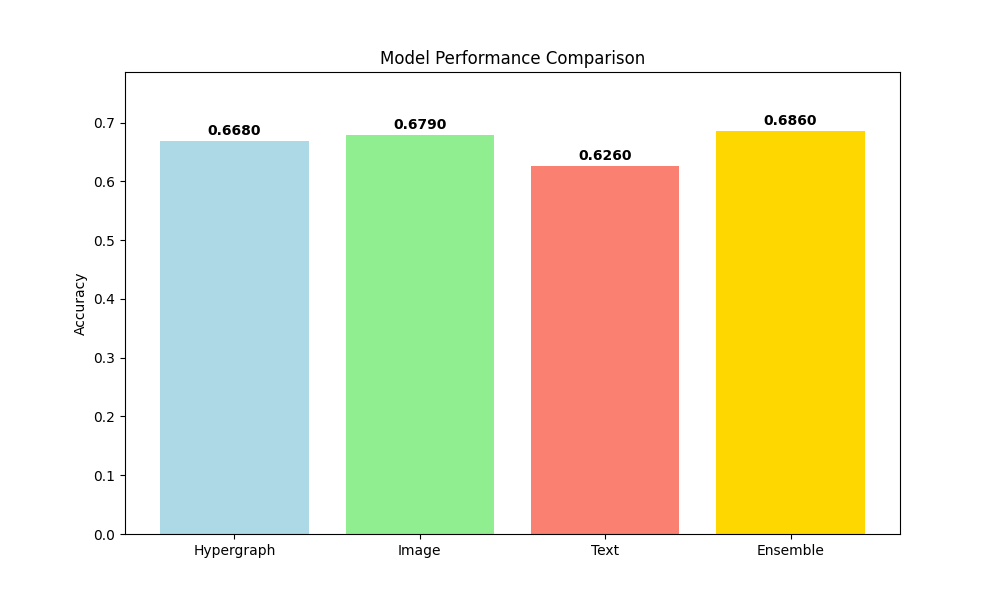

In [19]:
display(Image2(filename='/kaggle/working/model_comparison.png'))

## Save Models for Inference

### 1. `save_models(models, output_dir='./meme_virality_models')`
- A utility function that saves all essential components for inference.

### 2. Saved Components
- **Models**:
  - Hypergraph Model
  - Image Classification Model
  - Text Classification Model
- **Tokenizer**: Used for text preprocessing.
- **Scaler**: For tabular data normalization.
- **Transform Configuration**:
  - Saved as `transform_config.json`
  - Stores image transformation details.
- **Model Configuration**:
  - Saved as `model_config.json`
  - Includes model architecture and hyperparameters.

### 3. Output Directory
- All files are stored in: `./meme_virality_models`


In [20]:
import os
import torch
import joblib
import json
from huggingface_hub import HfApi, HfFolder, Repository
from huggingface_hub import login
from transformers import BertTokenizer

def save_models(models, output_dir='./meme_virality_models'):
    """
    Save all models and components needed for inference
    
    Args:
        models: Dictionary containing all models and components
        output_dir: Directory to save models to
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save hypergraph model
    torch.save(models['hypergraph_model'].state_dict(), 
               os.path.join(output_dir, 'hypergraph_model.pt'))
    
    # Save image model
    torch.save(models['image_model'].state_dict(), 
               os.path.join(output_dir, 'image_model.pt'))
    
    # Save text model
    models['text_model'].save_pretrained(os.path.join(output_dir, 'text_model'))
    
    # Save tokenizer
    models['tokenizer'].save_pretrained(os.path.join(output_dir, 'tokenizer'))
    
    # Save scaler
    joblib.dump(models['scaler'], os.path.join(output_dir, 'scaler.joblib'))
    
    # Save image transform parameters (can't save transforms directly)
    transform_config = {
        "resize": (224, 224),
        "normalize_mean": [0.485, 0.456, 0.406],
        "normalize_std": [0.229, 0.224, 0.225]
    }
    with open(os.path.join(output_dir, 'transform_config.json'), 'w') as f:
        json.dump(transform_config, f)
    
    # Save model architectures (hyperparameters)
    model_config = {
        "hypergraph": {
            "input_dim": models['hypergraph_model'].fc1.in_features,
            "hidden_dim": models['hypergraph_model'].fc1.out_features,
            "output_dim": models['hypergraph_model'].fc3.out_features
        }
    }
    with open(os.path.join(output_dir, 'model_config.json'), 'w') as f:
        json.dump(model_config, f)
    
    print(f"All models saved to {output_dir}")


# Save models for inference
models = {
    'hypergraph_model': hypergraph_model,
    'image_model': image_model,
    'text_model': text_model,
    'image_transform': image_transform,
    'tokenizer': tokenizer,
    'scaler': scaler
}


save_models(models, output_dir='./meme_virality_models')

print('\n\n Done\n\n')

All models saved to ./meme_virality_models


 Done




## Inference for 5 Samples

This section performs inference on 5 random test samples using the **tabular**, **image**, and **text** models, and combines their outputs using an ensemble.

---

### 📌 Steps Involved:

1. **🎲 Random Selection of Test Samples**
   - `test_indices = np.random.choice(len(y_test), size=5, replace=False)`
   - Randomly selects 5 samples from the test set.

2. **📦 Data Preparation**
   - **Tabular**: Extract features using `test_tab_features = X_tab_test[test_indices]`.
   - **Image**: Extract paths using `test_img_paths = image_paths[test_indices]`.
   - **Text**: Extract text using `test_texts = text_data[test_indices]`.
   - **Labels**: Get true labels using `true_labels = y_test[test_indices]`.

3. **👁️ Display True Labels**
   - Loop through each sample to display the original text and its **true virality label**.

4. **⚙️ Running Inference**
   - **Tabular**: Use `hypergraph_inference(test_tab_features)` for predictions.
   - **Image**: Use `image_inference(img_path)` for each image.
   - **Text**: Use `text_inference(text)` for each text sample.

5. **🧠 Ensemble Prediction**
   - Fuse predictions:  
     `ensemble_predictions = 0.2 * tab_probs + 0.4 * img_probs + 0.4 * txt_probs`
   - Select the class with the **highest fused probability**.

6. **📊 Displaying Predictions**
   - For each of the 5 samples, display:
     - **Tabular Prediction**
     - **Image Prediction**
     - **Text Prediction**
     - **Ensemble Prediction**

---

### Completion
- Prints the **predicted labels** from each individual model and the **ensemble result** for each of the 5 selected samples.


Device set to use cuda:0



--- Example Inference for 5 Samples ---

Sample 1
Text: Girls are allowed to masturbate in November because they don't nut
True virality: High

Sample 2
Text: wish DICE includes feature that erases We don't hate women all women and minorities from my or minorities! That's a gamell stupid strawman made up by rlgamingcirclejerk? rIBattlefield
True virality: High

Sample 3
Text: RETURL LAp h062] This is brilliant: TKSODE OM8621 But / like this: EbR
True virality: High

Sample 4
Text: When you go to the doctor and lie to the nurse on the depression related questions pulled a little sneaky on ya
True virality: Low

Sample 5
Text: When your mom asks you what you packed in your lunch for school
True virality: Low

📝 Text: Girls are allowed to masturbate in November because they don't nut
🔮 Predicted Class: LABEL_0 (0.93)


Device set to use cuda:0


  0%|          | 0/498 [00:00<?, ?it/s]


📝 Text: wish DICE includes feature that erases We don't hate women all women and minorities from my or minorities! That's a gamell stupid strawman made up by rlgamingcirclejerk? rIBattlefield
🔮 Predicted Class: LABEL_1 (1.00)


Device set to use cuda:0


  0%|          | 0/498 [00:00<?, ?it/s]


📝 Text: RETURL LAp h062] This is brilliant: TKSODE OM8621 But / like this: EbR
🔮 Predicted Class: LABEL_0 (0.96)


Device set to use cuda:0


  0%|          | 0/498 [00:00<?, ?it/s]


📝 Text: When you go to the doctor and lie to the nurse on the depression related questions pulled a little sneaky on ya
🔮 Predicted Class: LABEL_1 (1.00)


Device set to use cuda:0



📝 Text: When your mom asks you what you packed in your lunch for school
🔮 Predicted Class: LABEL_0 (0.98)


[0 1 0 0 0]
[[0.5002196  0.49978042]
 [0.49858022 0.50141984]
 [0.5001702  0.49982983]
 [0.5002196  0.49978042]
 [0.5002196  0.49978042]]

--- Results for Sample 1 ---
Hypergraph prediction: High
Image prediction: High
Text prediction: Low
Ensemble prediction: Low

--- Results for Sample 2 ---
Hypergraph prediction: High
Image prediction: High
Text prediction: High
Ensemble prediction: High

--- Results for Sample 3 ---
Hypergraph prediction: High
Image prediction: High
Text prediction: Low
Ensemble prediction: Low

--- Results for Sample 4 ---
Hypergraph prediction: High
Image prediction: High
Text prediction: High
Ensemble prediction: Low

--- Results for Sample 5 ---
Hypergraph prediction: High
Image prediction: High
Text prediction: Low
Ensemble prediction: Low


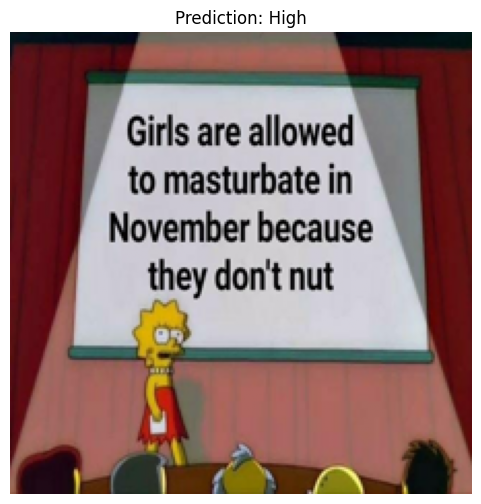

<Figure size 1200x400 with 0 Axes>

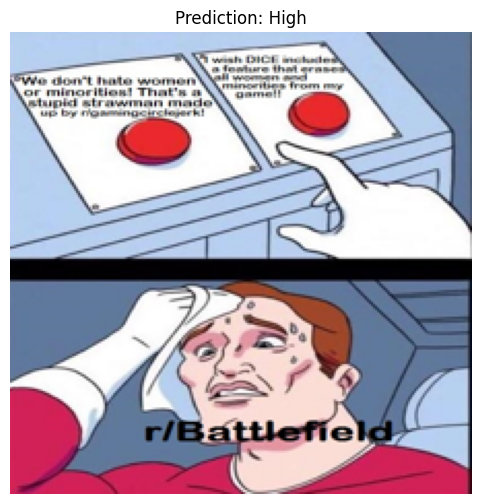

<Figure size 1200x400 with 0 Axes>

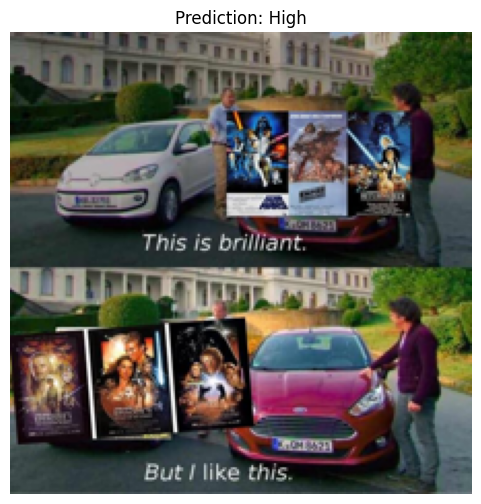

<Figure size 1200x400 with 0 Axes>

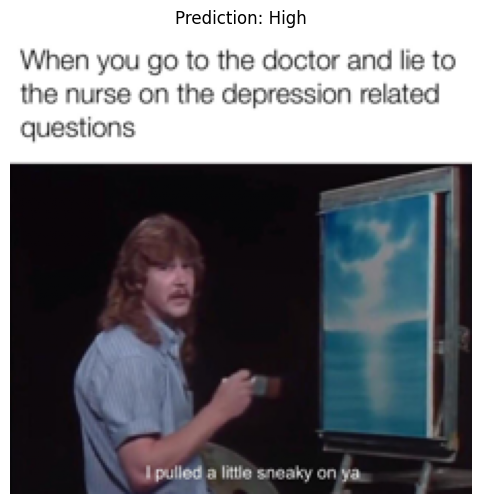

<Figure size 1200x400 with 0 Axes>

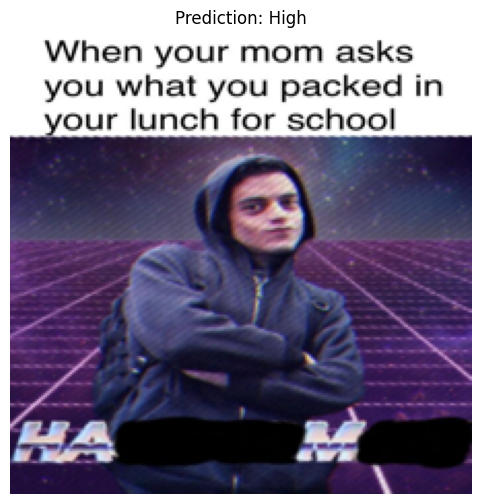

<Figure size 1200x400 with 0 Axes>

In [21]:
print("\n--- Example Inference for 5 Samples ---")

# Select 5 random indices
test_indices = np.random.choice(len(y_test), size=5, replace=False)

# Prepare 5 tabular samples
test_tab_features = X_tab_test.iloc[test_indices].reset_index(drop=True)

# Prepare 5 image paths
test_img_paths = X_img_test.iloc[test_indices]

# Prepare 5 text samples
test_texts = X_txt_test.iloc[test_indices]

# True labels
true_labels = y_test.iloc[test_indices]

for i in range(5):
    print(f"\nSample {i+1}")
    print(f"Text: {test_texts.iloc[i]}")
    print(f"True virality: {['Low', 'High'][true_labels.iloc[i]]}")

# Run inference on 5 tabular features (this will now work with k=5)
tab_pred, tab_prob = hypergraph_inference(hypergraph_model, test_tab_features, scaler)

# Inference for images (one at a time)
img_preds, img_probs, txt_preds, txt_probs = [], [], [], []

for i in range(5):
    img_pred, img_prob, _ = image_inference(image_model, test_img_paths.iloc[i], image_transform)
    txt_pred, txt_prob, _ = text_inference(text_model, test_texts.iloc[i], tokenizer)

    img_preds.append(img_pred[0])
    img_probs.append(img_prob[0])

    txt_preds.append(txt_pred[0])
    txt_probs.append(txt_prob[0])


ensemble_pred, ensemble_prob = ensemble_predictions(tab_pred, tab_prob, img_pred, img_prob, txt_pred, txt_prob)
print(ensemble_pred)
print(ensemble_prob)


# Print results
for i in range(5):
    print(f"\n--- Results for Sample {i+1} ---")
    print(f"Hypergraph prediction: {['Low','High'][tab_pred[i]]}")
    print(f"Image prediction: {['Low','High'][img_preds[i]]}")
    print(f"Text prediction: {['Low', 'High'][txt_preds[i]]}")
    print(f"Ensemble prediction: {['Low', 'High'][ensemble_pred[i]]}")
